<h1> <center> Database Parallelization Project (CMSE 401) <center/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sqlite3

import multiprocessing.pool
from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count

In [2]:
cancer_data = pd.read_csv("https://raw.githubusercontent.com/Hindrest/Database_Optimization_Project/main/breast_cancer.csv") #569 entries | small

us_school_data = pd.read_csv("https://raw.githubusercontent.com/Hindrest/Database_Optimization_Project/main/states_all_extended.csv")#1715 Entries | medium

best_buy_data = pd.read_csv("https://raw.githubusercontent.com/Hindrest/Database_Optimization_Project/main/bestbuy.csv") #15,120 entries | large

manga_data = pd.read_csv("https://raw.githubusercontent.com/Hindrest/Database_Optimization_Project/main/manga.csv") #67,273 entries | Large

In [3]:
print(cancer_data.shape)
print('')
print(us_school_data.shape)
print('')
print(best_buy_data.shape)
print('')
print(manga_data.shape)

(569, 33)

(1715, 266)

(15210, 6)

(67273, 31)


In [4]:
cpu_count()

256

<h1> <center>Part 1: Creating a database using sqlite3<center/>

In [5]:
#Initializing the database object to create the file as is
conn = sqlite3.connect('cmse_401_project_database')
cur = conn.cursor()

In [6]:
#A function to query the database without having to manually retype all of this every time
def query_db(query):
    conn = sqlite3.connect('cmse_401_project_database')
    cur = conn.cursor()
    cur.execute(query)
    if 'SELECT' in query:
        result = cur.fetchall()
        conn.close()
        return result
    conn.close()
    return

<h1> <center>Part 2: Benchmarking Insertion and Retrieval of Data<center/>

In [11]:
#Very basic dictionary used to hold the timing results
timing_data = {'Cancer Data':0,'US School Data':0,'Best Buy Data':0,'Manga Data':0}

In [26]:
start_time = time.time()
cancer_data.to_sql(name='cancer_data', con=conn, if_exists='replace', index=False)
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Cancer Data'] = (end_time - start_time)

start_time = time.time()
us_school_data.to_sql(name='us_school_data', con=conn, if_exists='replace', index=False)
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['US School Data'] = (end_time - start_time)

start_time = time.time()
best_buy_data.to_sql(name='best_buy_data', con=conn, if_exists='replace', index=False)
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Best Buy Data'] = (end_time - start_time)

start_time = time.time()
manga_data.to_sql(name='manga_data', con=conn, if_exists='replace', index=False)
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Manga Data'] = (end_time - start_time)

Total run time: 0.04691481590270996
Total run time: 0.2944786548614502
Total run time: 0.23247551918029785
Total run time: 6.223458290100098


In [27]:
timing_data

{'Cancer Data': 0.04691481590270996,
 'US School Data': 0.2944786548614502,
 'Best Buy Data': 0.23247551918029785,
 'Manga Data': 6.223458290100098}

Text(0.5, 1.0, 'Insertion time for varying Data Sizes')

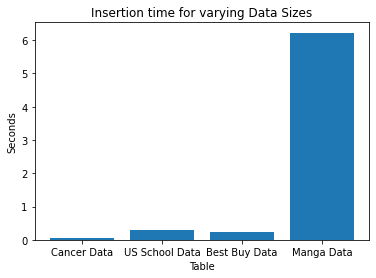

In [28]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Seconds')
plt.title('Insertion time for varying Data Sizes')

In [29]:
start_time = time.time()
query_db("SELECT * FROM cancer_data")
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Cancer Data'] = (end_time - start_time)

start_time = time.time()
query_db("SELECT * FROM us_school_data")
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['US School Data'] = (end_time - start_time)

start_time = time.time()
query_db("SELECT * FROM best_buy_data")
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Best Buy Data'] = (end_time - start_time)

start_time = time.time()
query_db("SELECT * FROM manga_data")
end_time = time.time()
print("Total run time:",end_time - start_time)
timing_data['Manga Data'] = (end_time - start_time)
base1 = timing_data
manga_base = timing_data['Manga Data']

Total run time: 0.024936199188232422
Total run time: 0.05270814895629883
Total run time: 0.02920699119567871
Total run time: 0.5801727771759033


In [31]:
timing_data

{'Cancer Data': 0.024936199188232422,
 'US School Data': 0.05270814895629883,
 'Best Buy Data': 0.02920699119567871,
 'Manga Data': 0.5801727771759033}

Text(0.5, 1.0, 'Query Times for Unoptimized Queries')

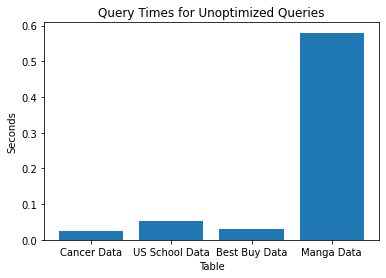

In [32]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Seconds')
plt.title('Query Times for Unoptimized Queries')

When pandas dataframes are converted into sql tables, the values are returned as tuples;

We can see this using the query below

In [13]:
cancer_data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [14]:
query_db("""SELECT id, diagnosis, radius_mean FROM cancer_data LIMIT 1""")

[(842302, 'M', 17.99)]

<h1> <center>Part 3: Optimizing data retrieval from a database<center/>

We are using multithreading to achieve parallelization of our queries

**With Threadpool**

In [15]:
# define the queries to be executed
queries = ["SELECT * FROM cancer_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Cancer Data'] = (end_time - start_time)
#print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM us_school_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['US School Data'] = (end_time - start_time)
#print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM best_buy_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Best Buy Data'] = (end_time - start_time)
#print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM manga_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Manga Data'] = (end_time - start_time)
#print(end_time - start_time)

In [16]:
timing_data

{'Cancer Data': 0.01537466049194336,
 'US School Data': 0.059957265853881836,
 'Best Buy Data': 0.04099750518798828,
 'Manga Data': 0.5090718269348145}

Text(0.5, 1.0, 'Optimized Query times w/ Threadpool')

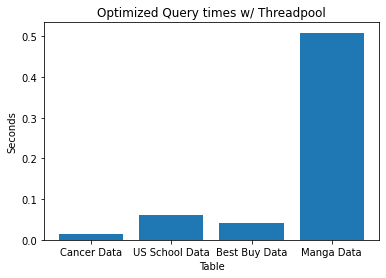

In [17]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Seconds')
plt.title('Optimized Query times w/ Threadpool')

**With Pool**

In [18]:
# define the queries to be executed
queries = ["SELECT * FROM cancer_data"]

# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Cancer Data'] = (end_time - start_time)
print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM us_school_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['US School Data'] = (end_time - start_time)
print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM best_buy_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Best Buy Data'] = (end_time - start_time)
print(end_time - start_time)

# define the queries to be executed
queries = ["SELECT * FROM manga_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Manga Data'] = (end_time - start_time)
print(end_time - start_time)

0.18683791160583496
0.11629295349121094
0.10711908340454102
1.0195527076721191


In [19]:
timing_data

{'Cancer Data': 0.18683791160583496,
 'US School Data': 0.11629295349121094,
 'Best Buy Data': 0.10711908340454102,
 'Manga Data': 1.0195527076721191}

Text(0.5, 1.0, 'Optimized Query times w/ Pool')

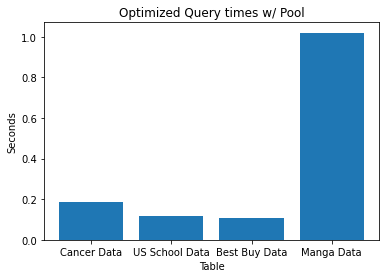

In [20]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Seconds')
plt.title('Optimized Query times w/ Pool')

<h1> Part 4.1: Investigation into bigger data

Benchmarking Higher Data with Unoptimized Queries, Optimized Queries w/ threading, and Optimized Queries with Pool

In [21]:
manga_base = timing_data['Manga Data']
timing_data = {}
timing_data['Manga Data'] = manga_base

In [22]:
# create a dummy DataFrame with 1,000,000 unique rows
table_one = pd.DataFrame({"Col 1": [f"{i}" for i in range(1000000)],"Col 2": [f"{i}" for i in range(1000000)]})
table_one.to_sql(name='table_one', con=conn, if_exists='replace', index=False)

# create a dummy DataFrame with 2,000,000 unique rows
table_two = pd.DataFrame({"Col 1": [f"{i}" for i in range(2000000)], "Col 2": [f"{i}" for i in range(2000000)]})
table_two.to_sql(name='table_two', con=conn, if_exists='replace', index=False)

# create a dummy DataFrame with 3,000,000 unique rows
table_three = pd.DataFrame({"Col 1": [f"{i}" for i in range(3000000)], "Col 2": [f"{i}" for i in range(3000000)]})
table_three.to_sql(name='table_three', con=conn, if_exists='replace', index=False)

# create a dummy DataFrame with 4,000,000 unique rows
table_four = pd.DataFrame({"Col 1": [f"{i}" for i in range(4000000)], "Col 2": [f"{i}" for i in range(4000000)]})
table_four.to_sql(name='table_four', con=conn, if_exists='replace', index=False)

**Unoptimized**

In [23]:
start_time = time.time()
query_db("""SELECT * FROM manga_data""")
end_time = time.time()
timing_data['Manga Data'] = (end_time - start_time)
print(end_time - start_time)

# execute the queries in parallel using a thread pool
start_time = time.time()
query_db("""SELECT * FROM table_one""")
end_time = time.time()
timing_data['Table One'] = (end_time - start_time)
print(end_time - start_time)

# execute the queries in parallel using a thread pool
start_time = time.time()
query_db("""SELECT * FROM table_two""")
end_time = time.time()
timing_data['Table Two'] = (end_time - start_time)
print(end_time - start_time)

# execute the queries in parallel using a thread pool
start_time = time.time()
query_db("""SELECT * FROM table_three""")
end_time = time.time()
timing_data['Table Three'] = (end_time - start_time)
print(end_time - start_time)

# execute the queries in parallel using a thread pool
start_time = time.time()
query_db("""SELECT * FROM table_four""")
end_time = time.time()
timing_data['Table Four'] = (end_time - start_time)
print(end_time - start_time)

base_higher_data = timing_data

0.5808172225952148
1.634765625
3.227726459503174
4.718907833099365
6.664623498916626


In [24]:
timing_data

{'Manga Data': 0.5808172225952148,
 'Table One': 1.634765625,
 'Table Two': 3.227726459503174,
 'Table Three': 4.718907833099365,
 'Table Four': 6.664623498916626}

Text(0.5, 1.0, 'Unoptimized Query Times on Higher Data')

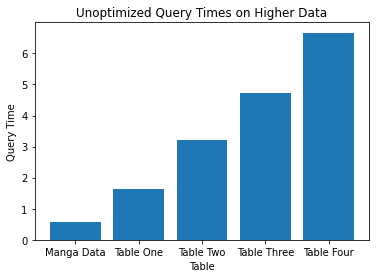

In [25]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Query Time')
plt.title('Unoptimized Query Times on Higher Data')

**With Threading**

In [26]:
queries = ["SELECT * FROM manga_data"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Manga Data'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_one"]

# execute the queries in parallel using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table One'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_two"]

# execute the queries in using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Two'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_three"]
# execute the queries using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Three'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_four"]
# execute the queries in using a thread pool
start_time = time.time()
results = ThreadPool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Four'] = (end_time - start_time)
print(end_time - start_time)

0.5775856971740723
1.421968936920166
2.918689012527466
4.460422039031982
6.4522058963775635


In [27]:
thread_higher_data = timing_data
timing_data

{'Manga Data': 0.5775856971740723,
 'Table One': 1.421968936920166,
 'Table Two': 2.918689012527466,
 'Table Three': 4.460422039031982,
 'Table Four': 6.4522058963775635}

Text(0.5, 1.0, 'Optimized Query Times w/ Higher Data (Threadpool)')

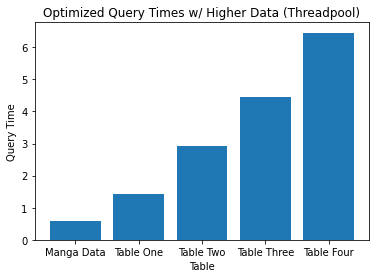

In [28]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Query Time')
plt.title('Optimized Query Times w/ Higher Data (Threadpool)')

**With Pool**

In [29]:
queries = ["SELECT * FROM manga_data"]

# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Manga Data'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_one"]

# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table One'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_two"]

# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Two'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_three"]
# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Three'] = (end_time - start_time)
print(end_time - start_time)

queries = ["SELECT * FROM table_four"]
# execute the queries in parallel using pool
start_time = time.time()
results = multiprocessing.Pool(4).map(query_db, queries)
end_time = time.time()
timing_data['Table Four'] = (end_time - start_time)
print(end_time - start_time)

1.5788512229919434
2.7909162044525146
5.197488307952881
7.879606246948242
10.710070848464966


In [30]:
pool_higher_data = timing_data
timing_data

{'Manga Data': 1.5788512229919434,
 'Table One': 2.7909162044525146,
 'Table Two': 5.197488307952881,
 'Table Three': 7.879606246948242,
 'Table Four': 10.710070848464966}

Text(0.5, 1.0, 'Optimized Query Times w/ Higher Data (Pool)')

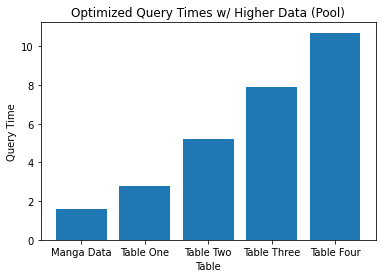

In [31]:
plt.bar(timing_data.keys(),timing_data.values())
plt.xlabel('Table')
plt.ylabel('Query Time')
plt.title('Optimized Query Times w/ Higher Data (Pool)')

<h1> Part 4.2: Does number of threads or workers matter?

Only Benchmarking unoptimized queries alongside optimized queries to see if the times w/ optimized queries can get better than normal queries

**Unoptimized**

In [57]:
manga_times = []
for i in range(1,21):
    start_time = time.time()
    query_db("""SELECT * FROM manga_data""")
    end_time = time.time()
    manga_times.append(end_time - start_time)
    timing_data['Manga Data'] = (end_time - start_time)
    print(end_time - start_time)

table_one_times = []
for i in range(1,21):
    # execute the queries in parallel using a thread pool
    start_time = time.time()
    query_db("""SELECT * FROM table_one""")
    end_time = time.time()
    table_one_times.append(end_time - start_time)
    timing_data['Table One'] = (end_time - start_time)
    print(end_time - start_time)

table_two_times = []
for i in range(1,21):
    # execute the queries in parallel using a thread pool
    start_time = time.time()
    query_db("""SELECT * FROM table_two""")
    end_time = time.time()
    table_two_times.append(end_time - start_time)
    timing_data['Table Two'] = (end_time - start_time)
    print(end_time - start_time)

table_three_times = []
for i in range(1,21):
    # execute the queries in parallel using a thread pool
    start_time = time.time()
    query_db("""SELECT * FROM table_three""")
    end_time = time.time()
    table_three_times.append(end_time - start_time)
    timing_data['Table Three'] = (end_time - start_time)
    print(end_time - start_time)

table_four_times = []
for i in range(1,21):
    # execute the queries in parallel using a thread pool
    start_time = time.time()
    query_db("""SELECT * FROM table_four""")
    end_time = time.time()
    table_four_times.append(end_time - start_time)
    timing_data['Table Four'] = (end_time - start_time)
    print(end_time - start_time)

0.519155740737915
0.49002623558044434
0.5016283988952637
0.48340868949890137
0.49256324768066406
0.4916062355041504
0.5023298263549805
0.48571014404296875
0.5011439323425293
0.5048809051513672
0.5390763282775879
0.5080387592315674
0.5080451965332031
0.5074326992034912
0.5041251182556152
0.48798251152038574
0.4928734302520752
0.48410844802856445
0.5015182495117188
0.4902498722076416
1.5892250537872314
1.4236271381378174
1.4270036220550537
1.390070915222168
1.3869681358337402
1.3821511268615723
1.422295093536377
1.4255027770996094
1.434253215789795
1.4624850749969482
1.4339663982391357
1.5029058456420898
1.6635942459106445
1.5350184440612793
1.401855707168579
1.4724688529968262
1.453751802444458
1.4438741207122803
1.4361841678619385
1.4124999046325684
3.050798177719116
3.083282470703125
3.372162342071533
3.064199924468994
3.0061981678009033
3.0931756496429443
3.0538253784179688
2.942288637161255
3.0119569301605225
2.952033281326294
3.044713258743286
3.088300943374634
3.0146381855010986
3

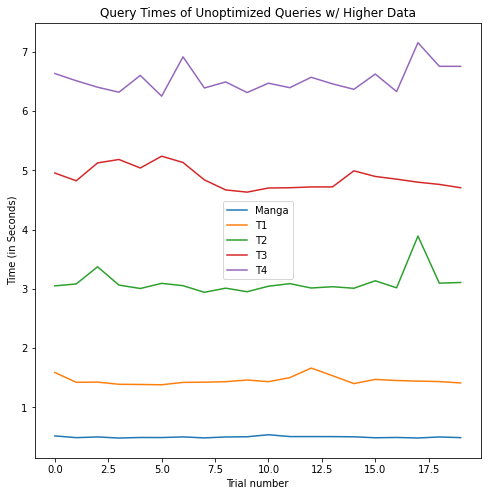

In [58]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.plot(x,manga_times,label='Manga')
plt.plot(x,table_one_times,label='T1')
plt.plot(x,table_two_times, label='T2')
plt.plot(x,table_three_times, label='T3')
plt.plot(x,table_four_times, label='T4')
plt.xlabel('Trial number')
plt.ylabel('Time (in Seconds)')
plt.title('Query Times of Unoptimized Queries w/ Higher Data')
plt.legend()

In [59]:
combined_times = []
for i in range(len(table_one_times)):
    combined_times.append(manga_times[i]+table_one_times[i]+table_two_times[i]+table_three_times[i]+table_four_times[i])

Text(0.5, 1.0, 'Combined times of Serially Unoptimized Queries (W/ Threadpool)')

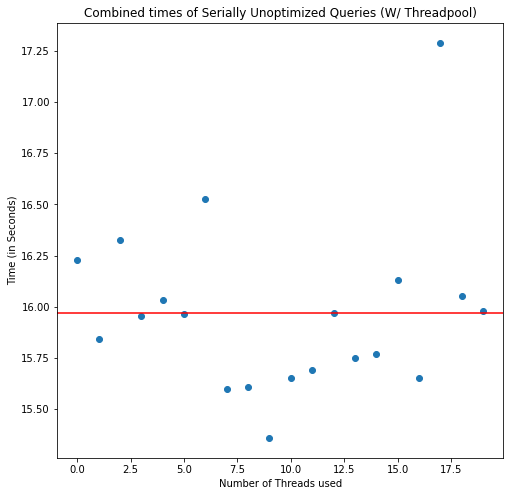

In [60]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.scatter(x,combined_times)
plt.axhline(y = np.mean(combined_times), color = 'r', linestyle = '-')
plt.xlabel('Number of Threads used')
plt.ylabel('Time (in Seconds)')
plt.title('Combined times of Serially Unoptimized Queries')

**With Threadpool**

In [61]:
timing_data = {}
timing_data['Manga Data'] = (end_time - start_time)

In [62]:
queries = ["SELECT * FROM manga_data"]

manga_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    manga_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Manga Data'] = manga_times

queries = ["SELECT * FROM table_one"]

table_one_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    table_one_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table One'] = table_one_times

queries = ["SELECT * FROM table_two"]

table_two_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    table_two_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Two'] = table_two_times

queries = ["SELECT * FROM table_three"]

table_three_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    table_three_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Three'] = table_three_times

queries = ["SELECT * FROM table_four"]

table_four_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    table_four_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Four'] = table_four_times

t1 = timing_data

2.109294891357422
0.5294764041900635
0.5447998046875
0.5252041816711426
0.5171253681182861
0.5240457057952881
0.5356521606445312
0.5295538902282715
0.5209715366363525
0.5207936763763428
0.5281517505645752
0.5354185104370117
0.5305707454681396
0.5266299247741699
0.526848554611206
0.5384197235107422
0.5229618549346924
0.5162854194641113
0.6703662872314453
0.5259313583374023
1.6179494857788086
1.5611505508422852
1.4728407859802246
1.4707891941070557
1.4625823497772217
1.4448471069335938
1.440415859222412
1.4655201435089111
1.4810986518859863
1.4884648323059082
1.5012989044189453
1.499537467956543
1.5298583507537842
1.537801742553711
1.4956426620483398
1.5790579319000244
1.5351004600524902
1.5292744636535645
1.5025560855865479
1.484738826751709
3.1945786476135254
3.067596673965454
3.027482032775879
2.9650144577026367
3.1661970615386963
3.033740997314453
3.0558693408966064
3.0967769622802734
3.040464401245117
3.185246706008911
3.524458169937134
3.3272624015808105
3.325201988220215
3.2206690

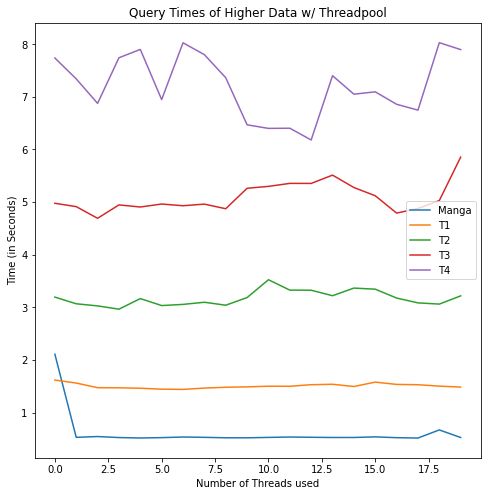

In [63]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.plot(x,manga_times,label='Manga')
plt.plot(x,table_one_times,label='T1')
plt.plot(x,table_two_times, label='T2')
plt.plot(x,table_three_times, label='T3')
plt.plot(x,table_four_times, label='T4')
plt.xlabel('Number of Threads used')
plt.ylabel('Time (in Seconds)')
plt.title('Query Times of Higher Data w/ Threadpool')
plt.legend()

In [64]:
combined_times = []
for i in range(len(table_one_times)):
    combined_times.append(manga_times[i]+table_one_times[i]+table_two_times[i]+table_three_times[i]+table_four_times[i])

Text(0.5, 1.0, 'Combined times of Serially Optimized Queries (W/ Threadpool)')

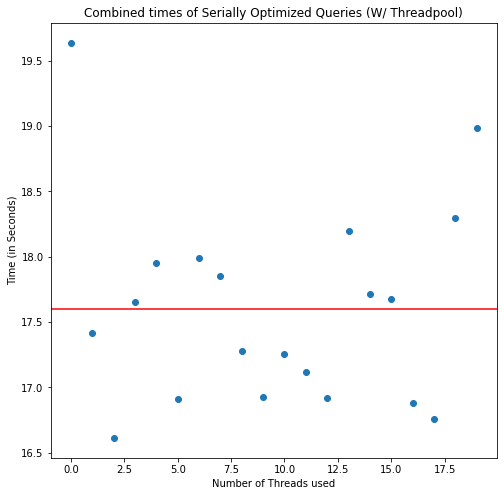

In [65]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.scatter(x,combined_times)
plt.axhline(y = np.mean(combined_times), color = 'r', linestyle = '-')
plt.xlabel('Number of Threads used')
plt.ylabel('Time (in Seconds)')
plt.title('Combined times of Serially Optimized Queries (W/ Threadpool)')

**With Pool**

In [66]:
timing_data = {}

In [67]:
queries = ["SELECT * FROM manga_data"]

manga_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    manga_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Manga Data'] = manga_times

queries = ["SELECT * FROM table_one"]

table_one_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    table_one_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table One'] = table_one_times

queries = ["SELECT * FROM table_two"]

table_two_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    table_two_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Two'] = table_two_times

queries = ["SELECT * FROM table_three"]

table_three_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    table_three_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Three'] = table_three_times

queries = ["SELECT * FROM table_four"]

table_four_times = []
# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    table_four_times.append(end_time - start_time)
    print(end_time - start_time)
timing_data['Table Four'] = table_four_times

t2 = timing_data

2.0902390480041504
1.4643657207489014
1.513780117034912
1.7211885452270508
1.6914701461791992
1.756606101989746
1.983339548110962
1.9426488876342773
2.034547805786133
2.0846211910247803
2.1446595191955566
2.277545928955078
2.3576478958129883
2.4623231887817383
2.4627256393432617
2.6034610271453857
2.610642910003662
2.7476353645324707
2.8626155853271484
2.886370897293091
2.769350528717041
2.96105694770813
3.151843547821045
3.2104744911193848
3.587430477142334
3.4977309703826904
3.516252279281616
3.5603747367858887
3.471622943878174
3.4923410415649414
3.6667263507843018
3.8459856510162354
4.04556941986084
4.077447414398193
4.321496486663818
4.1760101318359375
4.24255895614624
4.269028663635254
4.342722177505493
4.61017370223999
6.173131465911865
6.180660963058472
5.974329471588135
7.258104085922241
6.774991989135742
6.488354921340942
6.425877094268799
6.253742694854736
6.435255289077759
6.511824369430542
6.58613395690918
6.5898237228393555
6.802339792251587
6.7558112144470215
6.763895750

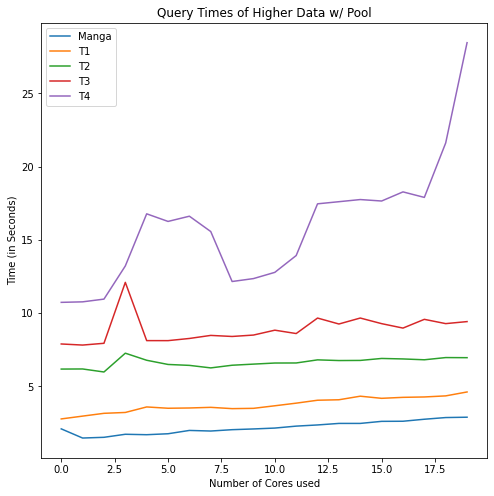

In [68]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.plot(x,manga_times,label='Manga')
plt.plot(x,table_one_times,label='T1')
plt.plot(x,table_two_times, label='T2')
plt.plot(x,table_three_times, label='T3')
plt.plot(x,table_four_times, label='T4')
plt.xlabel('Number of Cores used')
plt.ylabel('Time (in Seconds)')
plt.title('Query Times of Higher Data w/ Pool')
plt.legend()

In [69]:
combined_times = []
for i in range(len(table_one_times)):
    combined_times.append(manga_times[i] + table_one_times[i]+table_two_times[i]+table_three_times[i]+table_four_times[i])

Text(0.5, 1.0, 'Combined times of Serially Optimized Queries (W/ Pool)')

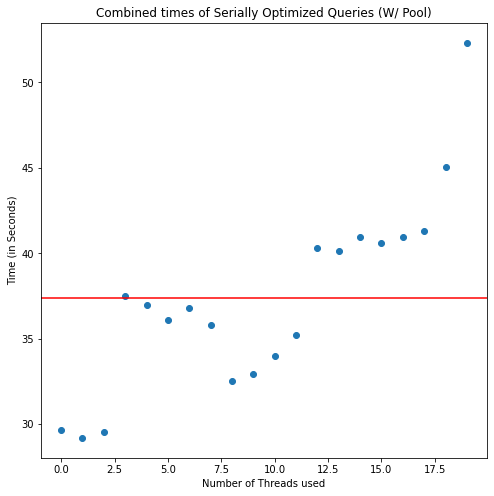

In [70]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.scatter(x,combined_times)
plt.axhline(y = np.mean(combined_times), color = 'r', linestyle = '-')
plt.xlabel('Number of Threads used')
plt.ylabel('Time (in Seconds)')
plt.title('Combined times of Serially Optimized Queries (W/ Pool)')

<h1> Part 5: Running Multiple Queries in parallel

In [42]:
timing_data = {}

In [43]:
queries = ["SELECT * FROM Manga_data",
           "SELECT * FROM table_one",
           "SELECT * FROM table_two",
           "SELECT * FROM table_three",
           "SELECT * FROM table_four"]

parallel_query_times = []

# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = ThreadPool(i).map(query_db, queries)
    end_time = time.time()
    parallel_query_times.append(end_time - start_time)
    print(end_time - start_time)

timing_data['Parallel Queries'] = parallel_query_times

16.574278831481934
16.672070264816284
30.995534896850586
48.81621217727661
62.49620580673218
66.88315463066101
76.89574360847473
52.31130623817444
61.78257203102112
60.96008849143982
58.77553915977478
60.52059721946716
59.0208477973938
65.34103226661682
66.67041683197021
81.66824626922607
69.54035925865173
57.17120957374573
57.30028033256531
58.6257164478302


In [44]:
parallel_pool_higher_data = timing_data
timing_data

{'Parallel Queries': [16.574278831481934,
  16.672070264816284,
  30.995534896850586,
  48.81621217727661,
  62.49620580673218,
  66.88315463066101,
  76.89574360847473,
  52.31130623817444,
  61.78257203102112,
  60.96008849143982,
  58.77553915977478,
  60.52059721946716,
  59.0208477973938,
  65.34103226661682,
  66.67041683197021,
  81.66824626922607,
  69.54035925865173,
  57.17120957374573,
  57.30028033256531,
  58.6257164478302]}

Text(0.5, 1.0, 'Parallelized Query Times w/ Threadpool')

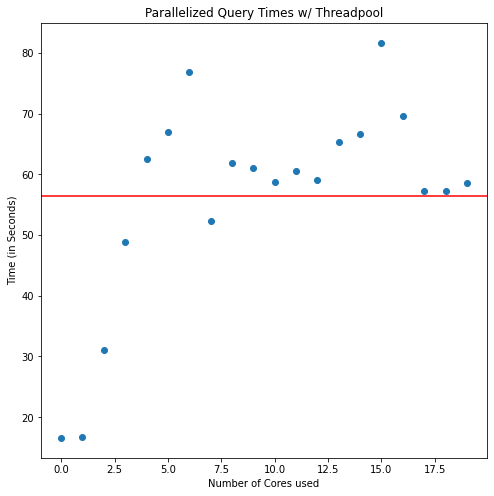

In [45]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.scatter(x,parallel_query_times)
plt.axhline(y = np.mean(parallel_query_times), color = 'r', linestyle = '-')
plt.xlabel('Number of Cores used')
plt.ylabel('Time (in Seconds)')
plt.title('Parallelized Query Times w/ Threadpool')

In [46]:
queries = ["SELECT * FROM Manga_data",
           "SELECT * FROM table_one",
           "SELECT * FROM table_two",
           "SELECT * FROM table_three",
           "SELECT * FROM table_four"]

parallel_query_times = []

# execute the queries in parallel using a thread pool
for i in range(1,21):
    start_time = time.time()
    results = multiprocessing.Pool(i).map(query_db, queries)
    end_time = time.time()
    parallel_query_times.append(end_time - start_time)
    print(end_time - start_time)

timing_data['Parallel Queries'] = parallel_query_times

30.214163303375244
17.48041605949402
14.237905979156494
12.985740184783936
12.318784236907959
11.676365852355957
12.934742450714111
12.495992422103882
12.377488851547241
13.016418218612671
14.116968154907227
15.228502750396729
14.959754943847656
13.502768516540527
13.648104667663574
13.467891931533813
13.53007197380066
13.35285758972168
13.545351505279541
13.516186952590942


In [47]:
parallel_thread_higher_data = timing_data
timing_data

{'Parallel Queries': [30.214163303375244,
  17.48041605949402,
  14.237905979156494,
  12.985740184783936,
  12.318784236907959,
  11.676365852355957,
  12.934742450714111,
  12.495992422103882,
  12.377488851547241,
  13.016418218612671,
  14.116968154907227,
  15.228502750396729,
  14.959754943847656,
  13.502768516540527,
  13.648104667663574,
  13.467891931533813,
  13.53007197380066,
  13.35285758972168,
  13.545351505279541,
  13.516186952590942]}

Text(0.5, 1.0, 'Parallelized Query Times w/ Pool')

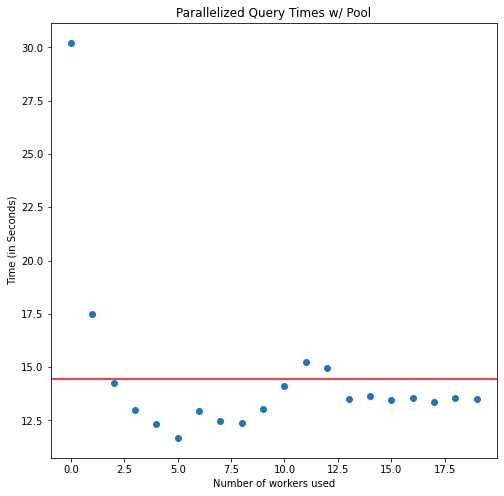

In [48]:
x = np.arange(0,20,1)
plt.figure(figsize=(8,8))
plt.scatter(x,parallel_query_times)
plt.axhline(y = np.mean(parallel_query_times), color = 'r', linestyle = '-')
plt.xlabel('Number of workers used')
plt.ylabel('Time (in Seconds)')
plt.title('Parallelized Query Times w/ Pool')

{'Cancer Data': 0.18683791160583496,
 'US School Data': 0.11629295349121094,
 'Best Buy Data': 0.10711908340454102,
 'Manga Data': 1.0195527076721191}

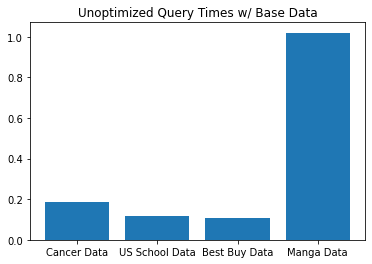

In [49]:
plt.bar(base1.keys(),base1.values())
plt.title("Unoptimized Query Times w/ Base Data")
base1

In [50]:
plt.bar(base2.keys(),base2.values())
plt.title("Unoptimized Query Times w/ Higher data")
base2

NameError: name 'base2' is not defined